Satyam

In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import dump, load

Shape of data: (1636, 98)

Columns:
 ['Index', 'Bankrupt?', 'ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-tax Net Profit Growth Rate', 'Regular Net Profit Growth Rate', 'Continuous 

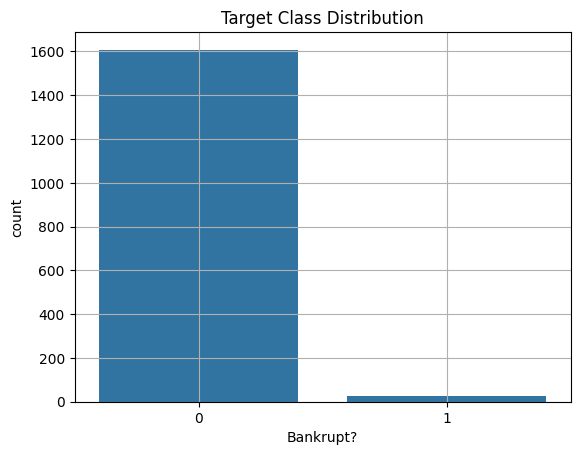


Statistical Summary:
              Index    Bankrupt?  \
count  1636.000000  1636.000000   
mean   2949.589853     0.017115   
std    1683.721536     0.129739   
min       0.000000     0.000000   
25%    1498.500000     0.000000   
50%    2995.000000     0.000000   
75%    4398.750000     0.000000   
max    5802.000000     1.000000   

       ROA(C) before interest and depreciation before interest  \
count                                        1636.000000         
mean                                            0.513494         
std                                             0.039690         
min                                             0.370107         
25%                                             0.487922         
50%                                             0.506874         
75%                                             0.533588         
max                                             0.780139         

       ROA(A) before interest and % after tax  \
count            

In [2]:
# SEED for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Load the dataset
df = pd.read_csv('artifacts/cluster_1_train.csv')
# df = pd.read_csv("D:\Stevens\ML Assignment\Project\Project\559-final-proj\artifacts\cluster_1_train.csv")

print("Shape of data:", df.shape)
print("\nColumns:\n", df.columns.tolist())

# EDA 
# Target distribution
target_dist = df['Bankrupt?'].value_counts(normalize=True)
print("\nTarget distribution (%):\n", target_dist * 100)

# Plot Target Balance
sns.countplot(data=df, x='Bankrupt?')
plt.title('Target Class Distribution')
plt.grid() 
plt.show()

# Statistical summary
print("\nStatistical Summary:\n", df.describe())

# Split features and target
X = df.drop(columns=['Bankrupt?', 'Index']) if 'Index' in df.columns else df.drop(columns=['Bankrupt?'])
y = df['Bankrupt?']

In [3]:
# SEED for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Step 1: Correlation Filtering
print("\n=== Correlation Filtering ===")
correlation = X.corrwith(y).sort_values(key=abs, ascending=False)
corr_threshold = 0.12  # Set correlation threshold
selected_corr_features = correlation[correlation.abs() >= corr_threshold].index.tolist()
X_corr_filtered = X[selected_corr_features]
print(f"Features retained after correlation filtering: {len(selected_corr_features)}")

# Step 2: VIF Filtering
print("\n=== VIF Filtering ===")
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_threshold = 1.2  # Set VIF threshold
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_corr_filtered), columns=X_corr_filtered.columns)
while True:
    vif = calculate_vif(X_scaled)
    max_vif = vif['VIF'].max()
    if max_vif > vif_threshold:
        drop_feature = vif.sort_values('VIF', ascending=False).iloc[0]['feature']
        print(f"Dropping '{drop_feature}' with VIF = {max_vif:.2f}")
        X_scaled = X_scaled.drop(columns=[drop_feature])
    else:
        break

X_vif_filtered = X_scaled
print(f"Features retained after VIF filtering: {X_vif_filtered.shape[1]}")
print("\nColumn names after VIF filtering:")
print(X_vif_filtered.columns.tolist())



# Train-test split on the filtered dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_vif_filtered, y, test_size=0.2, random_state=SEED, stratify=y
)
# Standardize the features after the train-test split
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on the training set
X_test_scaled = scaler.transform(X_test)       # Transform the test set using the same scaler


# dump(scaler,"artifacts/scaler_subgroup1.joblib")
print("Scaler saved as 'scaler_subgroup1.joblib'")


=== Correlation Filtering ===
Features retained after correlation filtering: 25

=== VIF Filtering ===
Dropping 'Net worth/Assets' with VIF = inf
Dropping 'Current Liabilities/Equity' with VIF = inf


C:\Users\user\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping 'Liability to Equity' with VIF = 355577759.62
Dropping 'Net profit before tax/Paid-in capital' with VIF = 109.57
Dropping 'After-tax net Interest Rate' with VIF = 108.86
Dropping 'Total debt/Total net worth' with VIF = 86.56
Dropping 'Net Income to Total Assets' with VIF = 76.21
Dropping 'ROA(B) before interest and depreciation after tax' with VIF = 69.77
Dropping 'Pre-tax net Interest Rate' with VIF = 32.27
Dropping 'ROA(A) before interest and % after tax' with VIF = 23.51
Dropping 'Per Share Net profit before tax (Yuan ¥)' with VIF = 19.68
Dropping 'Working Capital to Total Assets' with VIF = 14.83
Dropping 'Debt ratio %' with VIF = 10.47
Dropping 'Net Income to Stockholder's Equity' with VIF = 6.23
Dropping 'Borrowing dependency' with VIF = 5.24
Dropping 'Current Liability to Current Assets' with VIF = 4.89
Dropping 'Continuous interest rate (after tax)' with VIF = 4.43
Dropping 'Persistent EPS in the Last Four Seasons' with VIF = 3.93
Dropping 'ROA(C) before interest and d

In [4]:
# SEED for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Define base models
base_models = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),  # K-Nearest Neighbors
    ('dt', DecisionTreeClassifier(random_state=SEED)),  # Decision Tree
    ('rf', RandomForestClassifier(n_estimators=100, random_state=SEED))  # Random Forest Classifier
]
# Train a model on the scaled data
model = LogisticRegression(class_weight='balanced', random_state=SEED)

# Create the stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,  # Base models
    final_estimator=model,  # Meta-model
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),  # Cross-validation
    n_jobs=-1,  # Use all available processors
    passthrough=False  # Do not pass original features to the meta-model
)

# Perform cross-validation for base models and calculate TT, TF, and recall
print("Performing cross-validation and calculating TT, TF, and recall for base models...")
for name, model in base_models:
    print(f"\nEvaluating base model: {name}")
    y_pred_cv = cross_val_predict(
        model, X_train_scaled, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    )
    conf_matrix = confusion_matrix(y_train, y_pred_cv)
    TT = conf_matrix[1, 1]  # True Positives
    TF = conf_matrix[1, 0]  # False Negatives
    recall = TT / (TT + TF) if (TT + TF) > 0 else 0  # Avoid division by zero
    print(f"Confusion Matrix for {name}:\n{conf_matrix}")
    print(f"True Positives (TT) for {name}: {TT}")
    print(f"False Negatives (TF) for {name}: {TF}")
    print(f"Recall (TT / (TT + TF)) for {name}: {recall:.4f}")


# Perform cross-validation for the stacking model and calculate TT, TF, and recall
print("\nPerforming cross-validation and calculating TT, TF, and recall for the stacking model...")
y_pred_cv_stacking = cross_val_predict(
    stacking_model, X_train_scaled, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
)
conf_matrix_stacking = confusion_matrix(y_train, y_pred_cv_stacking)
TT_stacking = conf_matrix_stacking[1, 1]  # True Positives
TF_stacking = conf_matrix_stacking[1, 0]  # False Negatives
recall_stacking = TT_stacking / (TT_stacking + TF_stacking) if (TT_stacking + TF_stacking) > 0 else 0  # Avoid division by zero
print(f"Confusion Matrix for Stacking Model:\n{conf_matrix_stacking}")
print(f"True Positives (TT) for Stacking Model: {TT_stacking}")
print(f"False Negatives (TF) for Stacking Model: {TF_stacking}")
print(f"Recall (TT / (TT + TF)) for Stacking Model: {recall_stacking:.4f}")

# Train the stacking model on the scaled data
print("Training the stacking model...")
stacking_model.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
y_pred = stacking_model.predict(X_test_scaled)



Performing cross-validation and calculating TT, TF, and recall for base models...

Evaluating base model: knn
Confusion Matrix for knn:
[[1285    1]
 [  20    2]]
True Positives (TT) for knn: 2
False Negatives (TF) for knn: 20
Recall (TT / (TT + TF)) for knn: 0.0909

Evaluating base model: dt
Confusion Matrix for dt:
[[1265   21]
 [  20    2]]
True Positives (TT) for dt: 2
False Negatives (TF) for dt: 20
Recall (TT / (TT + TF)) for dt: 0.0909

Evaluating base model: rf
Confusion Matrix for rf:
[[1284    2]
 [  21    1]]
True Positives (TT) for rf: 1
False Negatives (TF) for rf: 21
Recall (TT / (TT + TF)) for rf: 0.0455

Performing cross-validation and calculating TT, TF, and recall for the stacking model...
Confusion Matrix for Stacking Model:
[[1211   75]
 [  13    9]]
True Positives (TT) for Stacking Model: 9
False Negatives (TF) for Stacking Model: 13
Recall (TT / (TT + TF)) for Stacking Model: 0.4091
Training the stacking model...
Evaluating the model on the test set...


In [5]:
# SEED for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Save base models
for name, model in base_models:
    print(f"Training and saving base model: {name}")
    print(f"Training {name} model...")
    print("X_train_scaled shape:", X_train_scaled.shape)
    model.fit(X_train_scaled, y_train)  # Train each base model
    # dump(model, f"artifacts/{name}_model_subgroup_1.joblib")  # Save the model
    print(f"Saved {name} model as {name}_model_subgroup_1.joblib")
    print("\n")

# Save the stacking model
stacking_model.fit(X_train_scaled, y_train)  # Train the stacking model
# dump(stacking_model, "artifacts/stacking_model_subgroup_1.joblib")  # Save the stacking model
print("Saved stacking model as 'stacking_model_subgroup_1.joblib'")
print("\n")

# Use the same features selected during training
selected_features = X_vif_filtered.columns.tolist()  # Ensure consistency with training
# dump(selected_features, "artifacts/selected_features_subgroup1.joblib")  # Save the selected features
print("Subgroup 0 transformation saved as 'selected_features_subgroup1.joblib'")



Training and saving base model: knn
Training knn model...
X_train_scaled shape: (1308, 4)
Saved knn model as knn_model_subgroup_1.joblib


Training and saving base model: dt
Training dt model...
X_train_scaled shape: (1308, 4)
Saved dt model as dt_model_subgroup_1.joblib


Training and saving base model: rf
Training rf model...
X_train_scaled shape: (1308, 4)
Saved rf model as rf_model_subgroup_1.joblib


Saved stacking model as 'stacking_model_subgroup_1.joblib'


Subgroup 0 transformation saved as 'selected_features_subgroup1.joblib'


In [6]:
# SEED for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Load the saved stacking model
# stacking_model = load("artifacts/stacking_model_subgroup_1.joblib")


print("Loaded stacking model from 'stacking_model_subgroup_1.joblib'.")

# Load the training dataset
df = pd.read_csv("artifacts/cluster_1_train.csv")  
print(f"Training dataset shape: {df.shape}")


X = df[selected_features]  # Use only the selected features
y = df["Bankrupt?"]

print("X shape:", X.shape)
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Predict on the entire training set stacking model
y_pred_stacking_model = stacking_model.predict(X_scaled)

# Evaluate performance on the training set : stacking model
conf_matrix_stacking_model = confusion_matrix(y, y_pred_stacking_model)
TT_stacking_model = conf_matrix_stacking_model[1, 1]  # True Positives
TF_stacking_model = conf_matrix_stacking_model[1, 0]  # False Negatives
recall_stacking = TT_stacking_model / (TT_stacking_model + TF_stacking_model) if (TT_stacking_model + TF_stacking_model) > 0 else 0  # Avoid division by zero

# Print evaluation metrics : stacking model
print(f"\nStacking model Confusion Matrix for Training Set stacking model:\n{conf_matrix_stacking_model}")
print(f"True Positives (TT) for Training Set stacking model: {TT_stacking_model}")
print(f"False Negatives (TF) for Training Set stacking model: {TF_stacking_model}")
print(f"Recall (TT / (TT + TF)) for Training Set stacking model: {recall_stacking:.4f}")


Loaded stacking model from 'stacking_model_subgroup_1.joblib'.
Training dataset shape: (1636, 98)
X shape: (1636, 4)

Stacking model Confusion Matrix for Training Set stacking model:
[[1519   89]
 [   5   23]]
True Positives (TT) for Training Set stacking model: 23
False Negatives (TF) for Training Set stacking model: 5
Recall (TT / (TT + TF)) for Training Set stacking model: 0.8214


In [7]:
import joblib

In [8]:
subgroup1_bundle = {
    "selected_features": selected_features,
    "scaler": scaler,
    "model": stacking_model
}

joblib_path = "artifacts/preprocessing_pipeline_subgroup1.joblib"
joblib.dump(subgroup1_bundle, joblib_path)

['artifacts/preprocessing_pipeline_subgroup1.joblib']